<a href="https://colab.research.google.com/github/ahsantfw/InceptionV3_TransferLearning/blob/main/InceptionV3_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-08-12 13:25:31--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   199MB/s    in 0.4s    

2022-08-12 13:25:32 (199 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Load the pre-trained weights
pre_trained_model = InceptionV3(
    input_shape = (150,150,3),
    include_top = False,
    weights = None
)

# Load the downloaded pre-trained weights 
pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

In [3]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [4]:
# Chosing an Intermediate layer
last_layer = pre_trained_model.get_layer('mixed7')

print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [5]:
from tensorflow.keras import Model
# Add dense layers in the end

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [6]:
from tensorflow.keras.optimizers import RMSprop

# Set the Training Parameters
model.compile(optimizer = RMSprop(learning_rate = 0.001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [7]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2022-08-12 13:25:43--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   156MB/s    in 0.4s    

2022-08-12 13:25:44 (156 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [8]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Extract the archive
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

# Define our example directories and files
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') 

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') 

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
#Train the Model

history = model.fit(train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = 100,
                    epochs = 20,
                    validation_steps = 50,
                    verbose = 2)

Epoch 1/20
100/100 - 34s - loss: 1.3856 - accuracy: 0.8360 - val_loss: 0.3537 - val_accuracy: 0.9190 - 34s/epoch - 339ms/step
Epoch 2/20
100/100 - 18s - loss: 0.4388 - accuracy: 0.8890 - val_loss: 0.3396 - val_accuracy: 0.9230 - 18s/epoch - 183ms/step
Epoch 3/20
100/100 - 18s - loss: 0.3830 - accuracy: 0.8980 - val_loss: 0.1949 - val_accuracy: 0.9550 - 18s/epoch - 182ms/step
Epoch 4/20
100/100 - 19s - loss: 0.3097 - accuracy: 0.9090 - val_loss: 0.1743 - val_accuracy: 0.9590 - 19s/epoch - 190ms/step
Epoch 5/20
100/100 - 18s - loss: 0.3154 - accuracy: 0.9155 - val_loss: 0.1638 - val_accuracy: 0.9620 - 18s/epoch - 181ms/step
Epoch 6/20
100/100 - 18s - loss: 0.2635 - accuracy: 0.9200 - val_loss: 0.1981 - val_accuracy: 0.9560 - 18s/epoch - 180ms/step
Epoch 7/20
100/100 - 18s - loss: 0.3020 - accuracy: 0.9250 - val_loss: 0.1328 - val_accuracy: 0.9660 - 18s/epoch - 179ms/step
Epoch 8/20
100/100 - 18s - loss: 0.2519 - accuracy: 0.9290 - val_loss: 0.1372 - val_accuracy: 0.9660 - 18s/epoch - 180

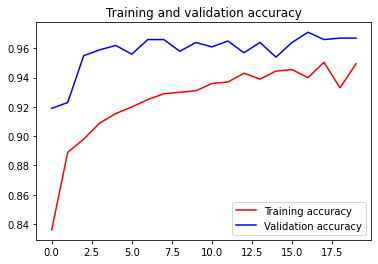

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()